In [2]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim

tng100 = sim.SimHandler('TNG100-1')

rng = np.random.default_rng()

In [30]:
from simim.galprops import prop_behroozi_sfr, prop_delooze_cii, prop_padmanabhan_cii, prop_yang_cii

# tng100.make_property(prop_behroozi_sfr, other_kws={'rng': rng}, overwrite=True, rename='sfr_behroozi', write=True)
# tng100.make_property(prop_delooze_cii, other_kws={'rng': rng}, overwrite=True, rename='LCII', kw_remap={'sfr': 'sfr_behroozi'}, write=True)
tng100.make_property(prop_yang_cii, other_kws={'rng': rng}, overwrite=True, rename='LCII', write=True)

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:312: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/siminterface/simhandler.py:582: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(name))
/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/_handlers.py:371: UserWarning: Property LCII already exists, overwriting
  warnings.warn("Property {} already exists, overwriting".format(property_name))


Assigning props for Snapshot 67.  


In [33]:
from astropy import constants as con
from astropy import units as u
from simim import constants as sc

zs = tng100.z_bins
MPC_TO_M = 3.0857e22
JY_CONVERSION = 1e26
def _calculate_Ldensity_to_Jy_conversion(nu_rest):
    """Conversion factor from Lsun/Mpc^3 to Jy/sr at redshift self.z."""
    # conversion factor
    conversion = (con.c.to(u.m/u.s).value / (4.0 * np.pi)) * \
        (sc.Lsun_to_W / MPC_TO_M**3) / (zsnap.cosmo.H(z).to(1/u.s).value * nu_rest) * JY_CONVERSION
    return conversion

Inucii = []
zciis = []

for z in zs:
    if z > 1.7 or z < 0.5:
        continue
    zsnap = tng100.get_snap_from_z(z)
    ciivals = zsnap.return_property('LCII', zsnap)
    volume = zsnap.box_edge ** 3
    conversion = _calculate_Ldensity_to_Jy_conversion(1900.5369e9)
    Inucii += [np.nansum(ciivals) / volume * conversion]
    zciis += [z]

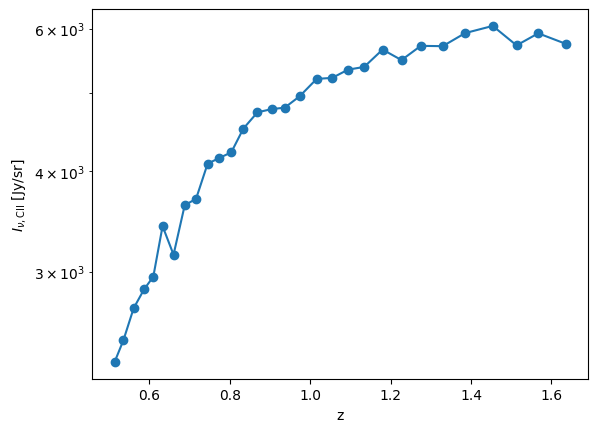

: 

In [ ]:
plt.figure()
plt.plot(zciis, Inucii, marker='o')
plt.yscale('log')
plt.xlabel('z')
plt.ylabel(r'$I_{\nu, \mathrm{CII}}$ [Jy/sr]')
plt.show()

In [ ]:
from simim.lightcone import LCMaker

gen = LCMaker(sim='TNG100-1',
            name='cii',
            openangle=1.0,
            aspect=0.2,
            mode = 'box',
            redshift_min = 0.5,
            redshift_max = 1.7,
            minimum_mass = 1e8)

gen.build_lightcones(rng=rng)
gen.add_properties('sfr_behroozi', 'LCII')

In [5]:
from simim.lightcone import LCHandler
lc1 = LCHandler('TNG100-1','cii',0)
V = lc1.volume()

import simim.siminterface as sim
tng100 = sim.SimHandler('TNG100-1')
n = tng100.number_volumes(V)

print(f"The number of lightcones we can fit in the TNG100 volume is {n:.1f}")

The number of lightcones we can fit in the TNG100 volume is 1.6


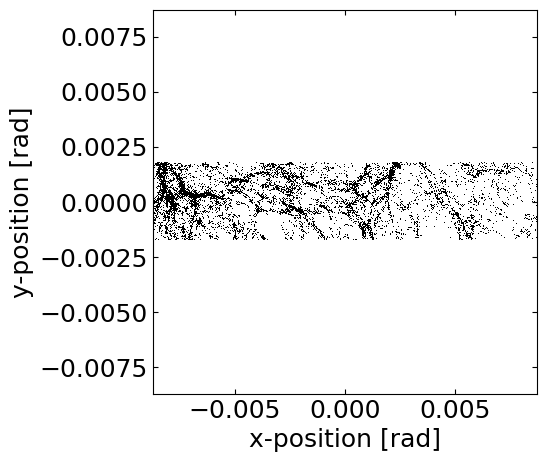

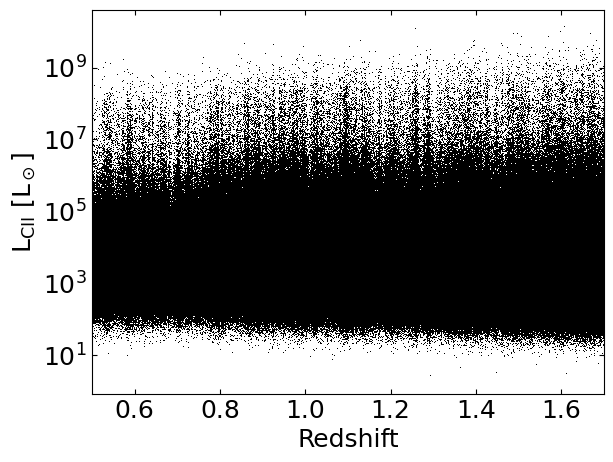

In [6]:
from simim.lightcone import LCHandler

lc1 = LCHandler('TNG100-1','cii',0)

lc1.set_property_range('redshift',0.999,1.001)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','LCII',
         axkws={'xlabel':'Redshift','ylabel':'L$_\mathregular{CII}$ [L$_\odot$]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

In [ ]:
from simim import constants as sc

pixel_size = tng100.box_edge_no_h / 450
z_for_modeling = 1.5
d = tng100.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / sc.nu_cii * (1+z_for_modeling)**2 / (1000*tng100.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d    

conv = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26

tng100_snap = tng100.get_snap_from_z(z_for_modeling)

grid = tng100_snap.grid('LCII', res=pixel_size, norm=conv)

In [6]:
ps = grid.power_spectrum(in_place=True,normalize=True)

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/map/gridder.py:1753: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


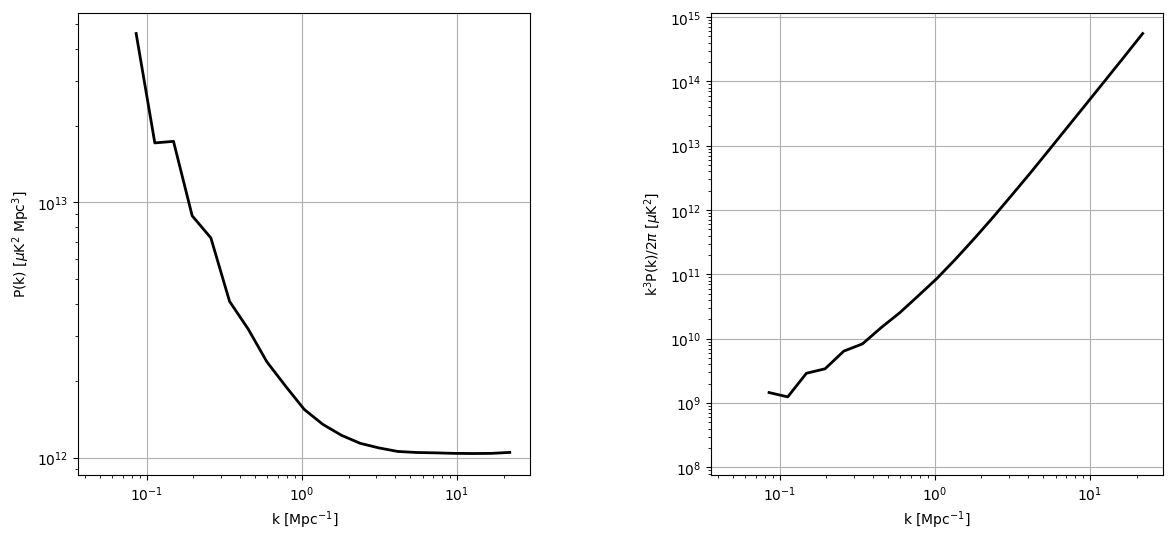

In [7]:
# Spherical average
bins = np.logspace(-3,3,51)
bin_centers = np.logspace(-2.95,2.95,50)
_,ps1d = ps.spherical_average(ax=[0,1,2],shells=bins)
ps1d = ps1d[:,0] / np.prod(grid.side_length)  # Normalize by volume
k = 2*np.pi * bin_centers

# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$\mu$K$^2$ Mpc$^{3}$]',xscale='log',yscale='log')
ax[0].grid()
ax[0].plot(k,ps1d,lw=2,color='k')
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$\mu$K$^2$]',xscale='log',yscale='log')
ax[1].plot(k,k**3/2/np.pi**2*ps1d,lw=2,color='k')
ax[1].grid()
plt.show()


In [117]:
from simim.galprops import Prop
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as con
import numpy as np


def I_HI(mass, redshift):
    if type(mass) == np.ndarray and mass.dtype != np.float64:
        mass = mass.astype(np.float64)
    # print(type(mass), mass.dtype)
    z = redshift
    alp, beta = 0.09, -0.5 # dimensionless
    Om, Ob, h = cosmo.Om(z), cosmo.Ob(z), cosmo.h
    vc0 = 10 ** 1.56 * u.km / u.s
    Y_He = 0.24
    fHc = (1.0 - Y_He) * Ob / Om
    Delta_v = 18 * np.pi ** 2 + 82 * (Om - 1) - 39 * (Om - 1) ** 2 # dimensionless
    RvM = 46.1 * (Delta_v * Om * h ** 2 / 24.4) ** (-1/3) * ((1+z) / 3.3) ** -1 \
            * (mass / 1e11) ** (1/3) * u.kpc
    vcM = np.sqrt(con.G * mass * con.M_sun / RvM).to(u.km / u.s)
    vterm = np.exp(-1.0 * (vc0 / vcM) ** 3)
    massHI = alp * fHc * (mass / 1e11 / h) ** beta * vterm * mass * con.M_sun
    A10 = 2.869e-15 / u.s
    dl = cosmo.luminosity_distance(z).to(u.cm) * (1 + z)
    I_HI = 3 * con.h * con.c / (21 * u.cm) * A10 * massHI / (4 * np.pi * dl ** 2) / con.u / u.sr / u.Hz
    I_HI = I_HI.to(u.Jy / u.sr).value
    # print(redshift, mass[np.isinf(I_HI)], I_HI[np.isinf(I_HI)])
    # print(redshift, mass[~ np.isinf(I_HI)])
    # I_HI[np.isnan(I_HI)] = 0
    # I_HI[np.isinf(I_HI)] = 0
    # had a problem here where some intermediate values were inf, so I had to increase from float32 to float64
    return I_HI

prop_I_HI = Prop(prop_name='I_HI',
                prop_function=I_HI,
                kwargs=['mass', 'redshift'],
                units="Jy/sr")

In [118]:
I_HI(np.array([4.2394481e+13]), 1.7435706)

array([1.09376809])

In [119]:
snap = tng100.get_snap_from_z(1.72)
masses = snap.return_property('mass')

In [120]:
len(masses), snap.redshift

(5527780, 1.7435706)

In [121]:
import matplotlib.pyplot as plt
import simim.siminterface as sim

tng100 = sim.SimHandler('TNG100-1')
tng100.make_property(prop_I_HI, overwrite=True, write=True)

Assigning props for Snapshot 67.  


In [124]:
from simim.lightcone import LCMaker

rng = np.random.default_rng()

gen = LCMaker(sim='TNG100-1',
              name='hi',
              openangle=1.0,
              aspect=1.0,
              mode = 'box',
              redshift_min = 0.5,
              redshift_max = 1.7,
              minimum_mass = 1e8)

gen.build_lightcones(rng=rng)
gen.add_properties('I_HI')

A file for light cones of this name already exists.
Light cones already saved may be overwritten.
Generating lines of sight.
Creating files and adding metadata.


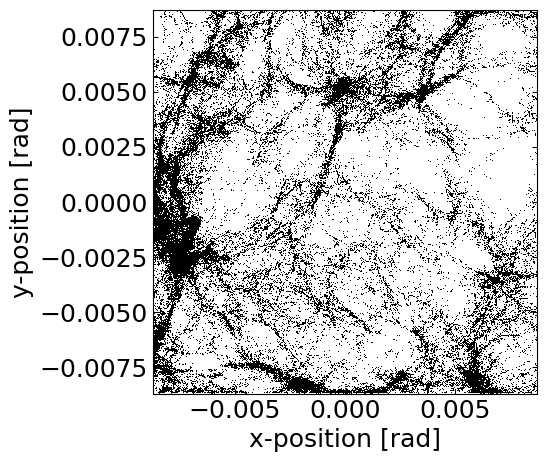

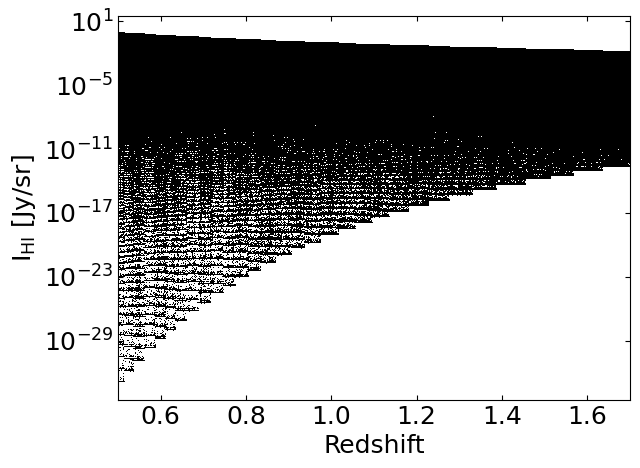

In [123]:
from simim.lightcone import LCHandler

lc1 = LCHandler('TNG100-1','hi',0)

lc1.set_property_range('redshift',0.999,1.001)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','I_HI',
         axkws={'xlabel':'Redshift','ylabel':'I$_\mathregular{HI}$ [Jy/sr]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

/Users/shubh/Library/CloudStorage/OneDrive-PennO365/TIM/crossLIM/simim_public/simim/map/gridder.py:1753: RuntimeWarning: invalid value encountered in divide
  binned_averages /= binned_weights


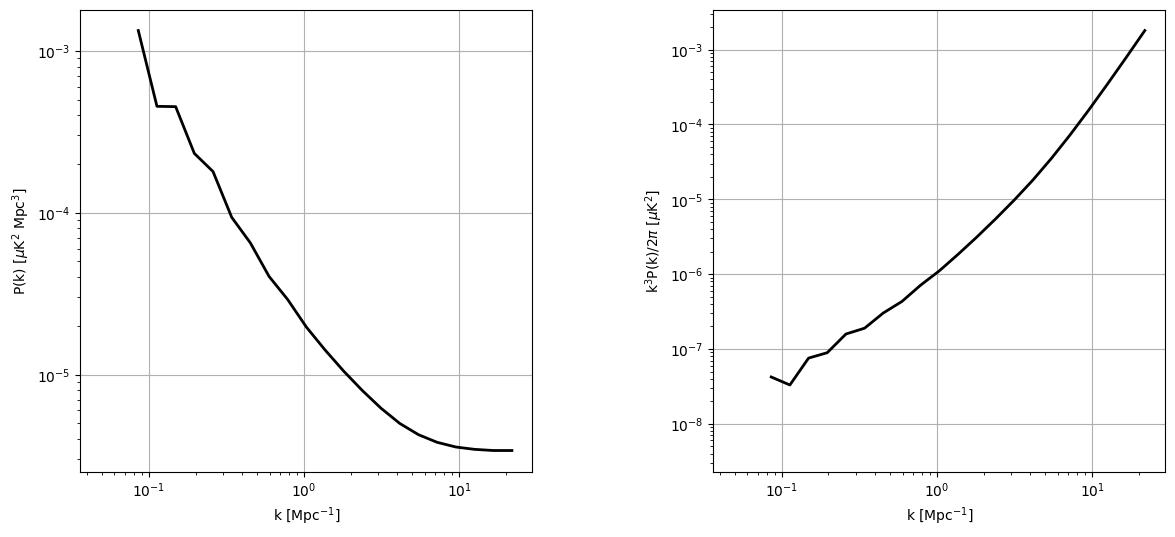

In [122]:
from simim import constants as sc

pixel_size = tng100.box_edge_no_h / 450
z_for_modeling = 1.0

tng100_snap = tng100.get_snap_from_z(z_for_modeling)

grid = tng100_snap.grid('I_HI', res=pixel_size)

ps = grid.power_spectrum(in_place=True,normalize=True)

# Spherical average
bins = np.logspace(-3,3,51)
bin_centers = np.logspace(-2.95,2.95,50)
_,ps1d = ps.spherical_average(ax=[0,1,2],shells=bins)
ps1d = ps1d[:,0] / np.prod(grid.side_length)  # Normalize by volume
k = 2*np.pi * bin_centers

# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$\mu$K$^2$ Mpc$^{3}$]',xscale='log',yscale='log')
ax[0].grid()
ax[0].plot(k,ps1d,lw=2,color='k')
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$\mu$K$^2$]',xscale='log',yscale='log')
ax[1].plot(k,k**3/2/np.pi**2*ps1d,lw=2,color='k')
ax[1].grid()
plt.show()


In [130]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim
from astropy import units as u, constants as con

tng100 = sim.SimHandler('TNG100-1')

rng = np.random.default_rng()

from simim import constants as sc
wl_co43 = sc.c / sc.nu_co43 * u.m
print(f"The wavelength of CO(4-3) is {wl_co43:.2e}")
print(con.c / wl_co43 / (210 * u.GHz) - 1)
print(con.c / wl_co43 / (420 * u.GHz) - 1)

The wavelength of CO(4-3) is 6.50e-04 m
1.1954322295238096
0.09771611476190478


In [129]:
sc.nu_co43 / 1e9

461.0407682